In [229]:
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import resnet50 
import preprocess.load_split_data as pr
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Subset,ConcatDataset
sns.set_theme(style="darkgrid")

In [191]:
torch.cuda.is_available()

True

In [192]:
device ="cuda" if torch.cuda.is_available() else "cpu"
#seed 
SEED=42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

## load data


In [193]:
# Load MNIST dataset
transform_mnist=transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(),
    # transforms.Normalize((0.1307,), (0.3081,))
])
class_mnist=pr.LoadDataset("MNIST",transform=transform_mnist)
mnist=class_mnist.load_dataset()

In [194]:
mnist

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./datasets
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./datasets
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
            ))

In [195]:
train_mnist,test_mnist=mnist

### Labeled data

In [196]:
# 1% of labeled data
tau=0.01
init_sample=int(tau*len(train_mnist))
labeled_indices=torch.randperm(len(train_mnist))[:init_sample]
initial_subset = Subset(train_mnist, labeled_indices)

In [197]:
labeled_indices

tensor([37542, 43087,  2992, 25810, 39634,  6425, 55768, 11034, 44310, 44384,
        23068, 47752, 37118, 26420, 46483, 45982, 57971, 42205,  1203, 10258,
        59229, 30716, 19083, 30280, 24611, 13538, 24923, 46281, 36903, 36959,
        10452, 53824,  7787, 55993, 49623,  7309, 23543, 53500, 12350, 16020,
        21306, 44185, 21283, 51268, 52539, 27188, 19459, 29066, 53997,  9785,
        57670, 27213, 36282, 54045, 29662, 59084, 18247, 57692, 16060, 31370,
        17306, 52258, 13180, 53326, 32838, 34376, 40257, 49627,  3747,  9922,
        55627, 52451, 18088, 18138, 16622, 42584, 25675, 26759, 21380, 23516,
        30054, 17416, 39226,  2161,  4726, 31870,  7385, 51486, 24131, 20818,
        26257,   561, 24881,  5415, 20119, 39000, 45769, 22627,  2851, 11918,
        26470, 45448, 39399,  1128, 43593, 32601, 36013, 19871, 31561, 54333,
        32015,  1443, 23255,  1277, 42374, 21964, 46024, 48175, 56523, 13693,
        21719, 21520, 29825,  1745, 11928, 58204,  8457, 13853, 

In [198]:
len(initial_subset)

600

### Unlabeled data

In [199]:
pool_indices = torch.randperm(len(train_mnist))[init_sample:len(train_mnist)]
pool_subset = Subset(train_mnist, pool_indices)

In [200]:
pool_indices

tensor([15658, 49260, 33067,  ..., 11047, 43759, 56020])

In [201]:
len(pool_subset)

59400

### Dataloader for labeled and unlabeled data

In [202]:
# Setup the batch size hyperparameter
BATCH_SIZE = 64

# Turn datasets into iterables (batches)
train_labeled_dataloader = DataLoader(initial_subset, # dataset to turn into iterable
    batch_size=BATCH_SIZE,# how many samples per batch?
    shuffle=True,
)
train_unlabeled_dataloader=DataLoader(pool_subset, # dataset to turn into iterable
    batch_size=BATCH_SIZE,# how many samples per batch?
    shuffle=True,
)
test_dataloader = DataLoader(test_mnist,
    batch_size=BATCH_SIZE,
    shuffle=False
)



In [203]:
train_labeled_dataloader

### Train on   the 1% labeled data

In [204]:
# Load the pre-trained ResNet50 model without pre-trained weights
model = resnet50(pretrained=False)

/home/nasserali/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nasserali/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [205]:
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Conversion en 3 canaux
model.fc = torch.nn.Linear(2048, 10)  # Modifier la couche de classification pour 10 classes

In [206]:
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [207]:
# Define the loss function
loss_function = torch.nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())


In [208]:
accuracy_dict={}

In [209]:
def train_evaluate(model, train_loader, test_loader ,optimizer, criterion, epochs):
    acc_train=[]
    # Train the model
    for epoch in range(epochs):
        for inputs, labels in train_labeled_dataloader :
            # Get the inputs and labels
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = loss_function(outputs, labels)

            # Backpropagate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate the model
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device) 
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            accuracy = correct / total
            acc_train.append(accuracy)

            print(f"Epoch {epoch + 1}: Accuracy {accuracy} for testing" )
    return acc_train


In [210]:
train=train_evaluate(model,train_labeled_dataloader,test_dataloader,optimizer,loss_function,5)
accuracy_dict['acc_1']=train

Epoch 1: Accuracy 0.3826 for testing
Epoch 2: Accuracy 0.627 for testing
Epoch 3: Accuracy 0.6964 for testing
Epoch 4: Accuracy 0.7635 for testing
Epoch 5: Accuracy 0.7957 for testing


In [211]:
accuracy_dict

{'acc_1': [0.3826, 0.627, 0.6964, 0.7635, 0.7957]}

In [212]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Active learning 

In [213]:
# Function to select the most uncertain samples for labeling (using model's prediction entropy)
def select_uncertain_samples(model, data_loader, n_samples):
    model.eval()
    uncertainties = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            # Get the inputs and labels
            inputs, _ = inputs.to(device), _
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            entropy = -torch.sum(probs * torch.log(probs), dim=1)
            uncertainties.extend(entropy.tolist())
    uncertainties = torch.tensor(uncertainties)
    uncertain_indices = uncertainties.argsort(descending=True)[:n_samples]
    return uncertain_indices


In [214]:
n_interation=10
n_uncertain_samples = 100
for i in range (n_interation) :

    uncertain_indices=select_uncertain_samples(model,train_unlabeled_dataloader,n_uncertain_samples)
    uncertain_indices.to(device)
    labeled_subset = Subset(pool_subset, uncertain_indices)
    initial_subset = ConcatDataset([initial_subset, labeled_subset])

    # Remove the labeled samples from the pool
    pool_indices = torch.tensor(list(set(pool_indices) - set(uncertain_indices.tolist())))
    pool_subset = Subset(train_mnist, pool_indices)
    pool_loader = DataLoader(pool_subset, batch_size=BATCH_SIZE, shuffle=True)

    # DataLoader for the updated labeled dataset
    initial_loader = DataLoader(initial_subset, batch_size=BATCH_SIZE, shuffle=True)
    # Train the model on the updated labeled dataset and Evaluate the model on the test set
    acc=train_evaluate(model, initial_loader, test_dataloader,optimizer,loss_function,5)
    accuracy_dict[f'acc_{i}']=acc

    

Epoch 1: Accuracy 0.1121 for testing
Epoch 2: Accuracy 0.1811 for testing
Epoch 3: Accuracy 0.3069 for testing
Epoch 4: Accuracy 0.3183 for testing
Epoch 5: Accuracy 0.414 for testing
Epoch 1: Accuracy 0.5376 for testing
Epoch 2: Accuracy 0.6507 for testing
Epoch 3: Accuracy 0.6766 for testing
Epoch 4: Accuracy 0.7575 for testing
Epoch 5: Accuracy 0.8107 for testing
Epoch 1: Accuracy 0.8302 for testing
Epoch 2: Accuracy 0.8121 for testing
Epoch 3: Accuracy 0.8443 for testing
Epoch 4: Accuracy 0.8487 for testing
Epoch 5: Accuracy 0.8579 for testing
Epoch 1: Accuracy 0.854 for testing
Epoch 2: Accuracy 0.8674 for testing
Epoch 3: Accuracy 0.8678 for testing
Epoch 4: Accuracy 0.8736 for testing
Epoch 5: Accuracy 0.8749 for testing
Epoch 1: Accuracy 0.8742 for testing
Epoch 2: Accuracy 0.8733 for testing
Epoch 3: Accuracy 0.8739 for testing
Epoch 4: Accuracy 0.8741 for testing
Epoch 5: Accuracy 0.8743 for testing
Epoch 1: Accuracy 0.8741 for testing
Epoch 2: Accuracy 0.8743 for testing
Epo

In [228]:
accuracy_dict

{'acc_1': [0.5376, 0.6507, 0.6766, 0.7575, 0.8107],
 'acc_0': [0.1121, 0.1811, 0.3069, 0.3183, 0.414],
 'acc_2': [0.8302, 0.8121, 0.8443, 0.8487, 0.8579],
 'acc_3': [0.854, 0.8674, 0.8678, 0.8736, 0.8749],
 'acc_4': [0.8742, 0.8733, 0.8739, 0.8741, 0.8743],
 'acc_5': [0.8741, 0.8743, 0.8753, 0.875, 0.8752],
 'acc_6': [0.8748, 0.8747, 0.8746, 0.8749, 0.875],
 'acc_7': [0.8747, 0.8749, 0.875, 0.8749, 0.8751],
 'acc_8': [0.8748, 0.8748, 0.8746, 0.8749, 0.8749],
 'acc_9': [0.8746, 0.8745, 0.8747, 0.875, 0.8749]}

In [263]:
table=[acc[4] for acc in accuracy_dict.values()]

In [267]:
data = {
    'numbers of epochs': [i for i in range(1,11)],
    'accuracy': sorted(table)
}
t = pd.DataFrame(data)

In [268]:
t

,numbers of epochs,accuracy
0,1,0.4140
1,2,0.8107
2,3,0.8579
3,4,0.8743
4,5,0.8749
5,6,0.8749
6,7,0.8749
7,8,0.8750
8,9,0.8751
9,10,0.8752


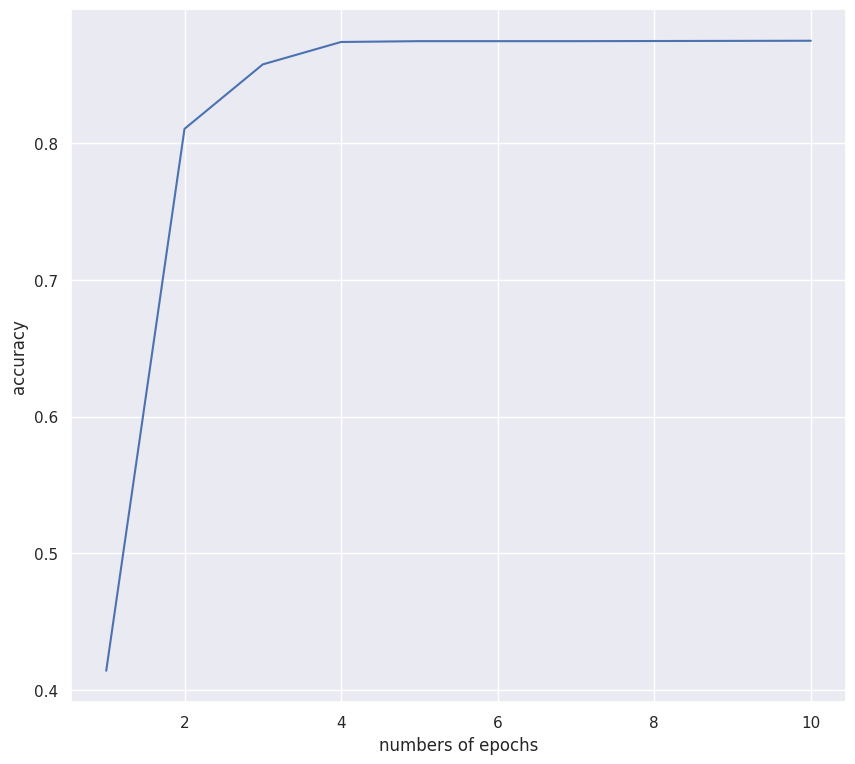

In [277]:
plt.figure(figsize=(10, 9))
sns.lineplot(x='numbers of epochs', y='accuracy', data=t)
plt.savefig("./figures/first_test_al.png")
plt.show()


In [215]:
# save_folder='./models/model-resnet50_mnist'
# model_path = os.path.join(save_folder)
# torch.save(model.state_dict(), model_path)

In [216]:
# model_state_dict = torch.load("./models/model-resnet50_mnist")

In [217]:
# model.load_state_dict(model_state_dict)

In [218]:
# model.eval()

In [219]:

# train_features_batch, train_labels_batch = next(iter(train_dataloader))
# train_features_batch.shape, train_labels_batch



In [220]:
# train_dataloader.dataset[0][0].shape

In [221]:
# torch.unsqueeze(train_dataloader.dataset[0][0],0).shape

In [222]:
# pred_1=model(torch.unsqueeze(train_dataloader.dataset[0][0],0))

In [223]:
# torch.argmax(pred_1)

In [224]:
# pred=model(train_features_batch)

In [225]:
# pred[2]

In [226]:
# torch.argmax(pred[1]
#              )

In [227]:
# np.random.randint(5,8,(5,5,3))